# First data imports and visualization

## imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import datetime
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from utils import market_values, market_values_by_time_index, nodal_balance, carrier_colors

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# n.export_to_csv_folder("../data/processed/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

## key data
- 365 * 24 / 3 = 2920 snapshots over one year (every 3 hours) -> rows
- 3086 different buses
- 181 different locations (+ EU: 182)
- 1707 different generators
- 8375 links
- 1635 stores
- 170 storage units


In [4]:
# number of buses
n.storage_units

,carrier,max_hours,efficiency_store,capital_cost,p_nom,bus,p_min_pu,cyclic_state_of_charge,efficiency_dispatch,marginal_cost,...,q_set,sign,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
AT0 0 hydro,hydro,453.342322,0.000000,0.000000,312.000000,AT0 0,0.0,True,0.900000,0.009920,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 PHS,PHS,4.441128,0.866025,160627.143522,2412.000000,AT0 1,-1.0,True,0.866025,0.010793,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 hydro,hydro,370.323700,0.000000,0.000000,1405.484076,AT0 1,0.0,True,0.900000,0.009380,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 PHS,PHS,286.054228,0.866025,160627.143522,1829.300000,AT0 2,-1.0,True,0.866025,0.009412,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 hydro,hydro,531.157368,0.000000,0.000000,4421.620000,AT0 2,0.0,True,0.900000,0.010034,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 7 hydro,hydro,2958.226813,0.000000,0.000000,1980.552563,SE3 7,0.0,True,0.900000,0.009320,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 PHS,PHS,6.000000,0.866025,160627.143522,185.000000,SI0 0,-1.0,True,0.866025,0.010539,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 hydro,hydro,3269.745194,0.000000,0.000000,730.790000,SI0 0,0.0,True,0.900000,0.009785,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0


In [5]:
# Energy carrier, such as AC, DC, heat, wind, PV or coal. Buses have direct carriers and Generators indicate their primary energy carriers. The Carrier can track properties relevant for global constraints, such as CO2 emissions.
n.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
onwind,0.0,#235ebc,Onshore Wind,inf
offwind-ac,0.0,#6895dd,Offshore Wind (AC),inf
offwind-dc,0.0,#74c6f2,Offshore Wind (DC),inf
solar,0.0,#f9d002,Solar,inf
PHS,0.0,#08ad97,Pumped Hydro Storage,inf
hydro,0.0,#08ad97,Reservoir & Dam,inf
ror,0.0,#4adbc8,Run of River,inf
co2,-1.0,,,inf
gas,0.0,,,inf


In [6]:
# counts of generators by carrier
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [7]:
# show the generators (electricity feed in) over time
n.generators_t.p
# 1707 different generators

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [8]:
# 3086 nodes / buses: Electrically fundamental node where x-port objects attach.
n.buses

,v_nom,x,y,country,control,generator,carrier,location,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL0 0,380.0,19.894573,41.561804,AL,Slack,AL0 0 offwind-ac,AC,AL0 0,,None,1.0,0.0,inf,
AT0 0,380.0,15.759790,47.898676,AT,PQ,,AC,AT0 0,,None,1.0,0.0,inf,
AT0 1,380.0,10.293250,47.248827,AT,PQ,,AC,AT0 1,,None,1.0,0.0,inf,
AT0 2,380.0,13.580650,47.413095,AT,PQ,,AC,AT0 2,,None,1.0,0.0,inf,
BA0 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA0 0,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 5,,None,1.0,0.0,inf,
SE3 6 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 6,,None,1.0,0.0,inf,
SE3 7 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 7,,None,1.0,0.0,inf,


In [9]:
# PQ power consumer.
n.loads_t.p

Load,AL0 0,AL0 0 H2 for industry,AL0 0 H2 for shipping,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 land transport fuel cell,AL0 0 low-temperature heat for industry,AL0 0 residential rural heat,...,SK0 0 services urban decentral heat,SK0 0 urban central heat,agriculture machinery oil,agriculture machinery oil emissions,gas for industry,kerosene for aviation,naphtha for industry,oil emissions,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,300.421829,3.424658,21.714866,0.0,0.0,206.621005,36.170330,11.263927,4.56621,213.365135,...,477.914964,1752.239936,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-01-01 03:00:00,193.027966,3.424658,21.714866,0.0,0.0,206.621005,92.444256,56.358211,4.56621,370.876901,...,708.682832,2851.279604,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-01-01 06:00:00,178.781684,3.424658,21.714866,0.0,0.0,206.621005,310.536312,118.068005,4.56621,393.184313,...,698.651493,2933.248873,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-01-01 09:00:00,238.642397,3.424658,21.714866,0.0,0.0,206.621005,276.317265,92.174636,4.56621,353.901262,...,589.105502,2569.463053,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-01-01 12:00:00,257.383976,3.424658,21.714866,0.0,0.0,206.621005,283.985764,107.086891,4.56621,343.217923,...,547.445262,2450.055718,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,317.809501,3.424658,21.714866,0.0,0.0,206.621005,272.020775,91.435876,4.56621,290.084021,...,471.066279,2070.145560,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-12-31 12:00:00,333.412768,3.424658,21.714866,0.0,0.0,206.621005,282.750420,106.552595,4.56621,281.610073,...,438.376548,1976.449661,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402
2013-12-31 15:00:00,370.846214,3.424658,21.714866,0.0,0.0,206.621005,343.188761,121.695238,4.56621,305.961119,...,438.358099,2083.622042,9888.803758,-2669.977015,30237.442922,69891.065138,37417.808219,-27661.751971,-15767.123288,80182.648402


In [10]:
# Storage unit with fixed nominal-energy-to-nominal-power ratio.
n.storage_units

,carrier,max_hours,efficiency_store,capital_cost,p_nom,bus,p_min_pu,cyclic_state_of_charge,efficiency_dispatch,marginal_cost,...,q_set,sign,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
AT0 0 hydro,hydro,453.342322,0.000000,0.000000,312.000000,AT0 0,0.0,True,0.900000,0.009920,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 PHS,PHS,4.441128,0.866025,160627.143522,2412.000000,AT0 1,-1.0,True,0.866025,0.010793,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 hydro,hydro,370.323700,0.000000,0.000000,1405.484076,AT0 1,0.0,True,0.900000,0.009380,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 PHS,PHS,286.054228,0.866025,160627.143522,1829.300000,AT0 2,-1.0,True,0.866025,0.009412,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 hydro,hydro,531.157368,0.000000,0.000000,4421.620000,AT0 2,0.0,True,0.900000,0.010034,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 7 hydro,hydro,2958.226813,0.000000,0.000000,1980.552563,SE3 7,0.0,True,0.900000,0.009320,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 PHS,PHS,6.000000,0.866025,160627.143522,185.000000,SI0 0,-1.0,True,0.866025,0.010539,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 hydro,hydro,3269.745194,0.000000,0.000000,730.790000,SI0 0,0.0,True,0.900000,0.009785,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0


## network visualization

In [11]:
m = n.copy()
m.mremove("Bus",m.buses[n.buses.x == 0].index )

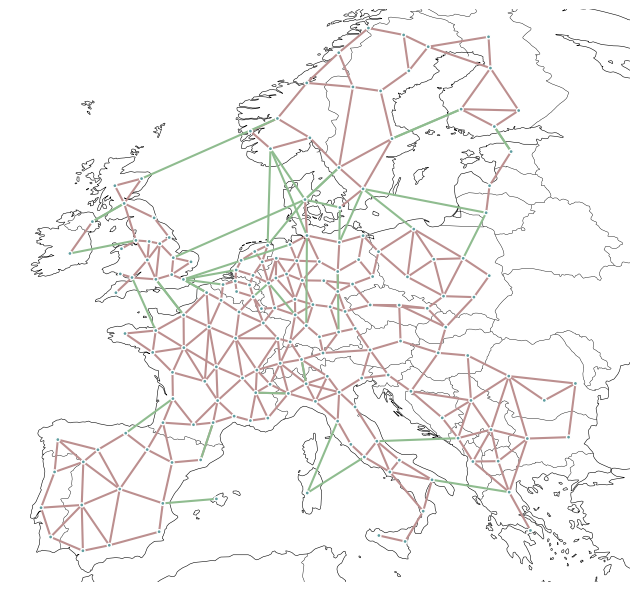

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

m.plot(ax=ax, projection=ccrs.EqualEarth())
plt.show()

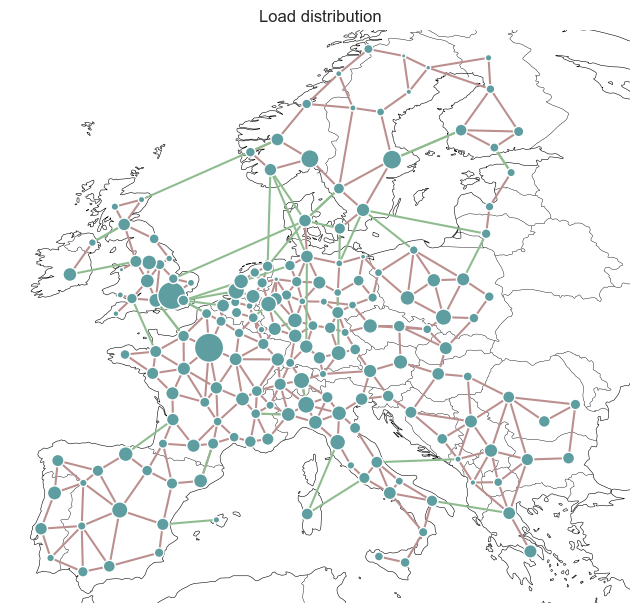

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

bus_locs = pd.Index(m.buses.location.unique())
load_distribution = m.loads_t.p[bus_locs].sum()/m.loads_t.p[bus_locs].sum().max()

m.plot(bus_sizes=1*load_distribution, ax=ax, title="Load distribution", projection=ccrs.EqualEarth())
plt.show()

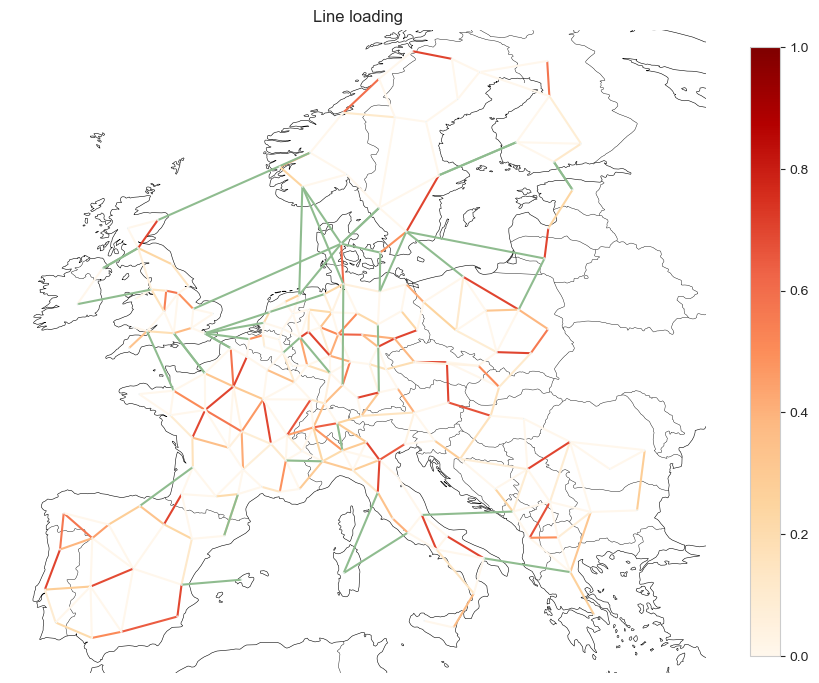

In [14]:
# line loading plot
snap = n.snapshots[0]
loading = m.lines_t.p0.loc[snap] / m.lines.s_nom
loading[loading.isnull()] = 0

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))
cmap= plt.cm.OrRd
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

colors = list(map(mcolors.to_hex, cmap(norm(loading))))

m.plot(
    ax=ax,
    line_colors=colors,
    line_cmap=plt.cm.jet,
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)

plt.colorbar(sm, orientation='vertical', shrink=0.7, ax=ax)
fig.tight_layout()

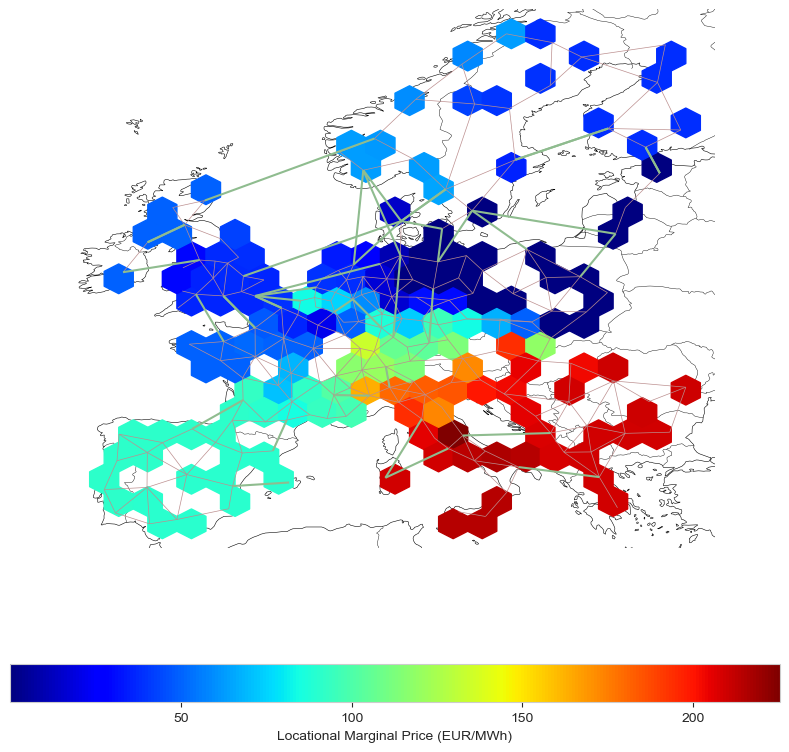

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    m.buses.x,
    m.buses.y,
    gridsize=20,
    C=m.buses_t.marginal_price.loc[m.snapshots[0]],
    cmap=plt.cm.jet,
    zorder=3,
)
m.plot(ax=ax, line_widths=pd.Series(0.5, m.lines.index), bus_sizes=0)

cb = plt.colorbar(location="bottom")
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()

## Generation & Consumption

#### AC

In [16]:
carrier = ["AC"]
nb_ac = nodal_balance(n, carrier = carrier, time="2013", aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW
nb_ac = nb_ac.unstack(level=[1]) / 1000
nb_ac.head()

carrier,AC,DAC,DC,H2 Electrolysis,H2 Fuel Cell,OCGT,PHS,battery charger,battery discharger,electricity distribution grid,hydro,offwind-ac,offwind-dc,onwind,ror,solar,urban central gas CHP,urban central gas CHP CC,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.182343e-14,-4.701310,1.818989e-15,-2086.685643,NaN,NaN,-8.191668,-27.560361,123.896068,-1976.676901,97.848250,110.147030,290.339413,3345.135572,36.961663,NaN,26.784181,0.002446,72.685865
2013-01-01 03:00:00,1.455192e-14,-4.701299,-2.728484e-15,-1902.041094,NaN,NaN,2.064618,-30.929961,151.412917,-1991.751074,103.750195,90.304507,262.427670,3167.278726,37.056465,NaN,42.072599,0.002457,73.037867
2013-01-01 06:00:00,-2.182787e-14,-4.701317,2.273737e-15,-1845.437240,NaN,NaN,-9.096095,-102.300655,41.880398,-2134.094169,107.561415,90.908931,297.254347,2966.033733,37.467863,474.250993,7.057945,0.002455,73.186171
2013-01-01 09:00:00,1.045919e-14,-4.702031,0.000000e+00,-2721.089244,NaN,NaN,-71.164409,-471.463154,0.808012,-2310.703684,73.847600,81.739914,318.302632,2498.930801,37.925187,2495.548835,NaN,0.000776,71.994589
2013-01-01 12:00:00,-3.819878e-14,-4.702128,-9.094947e-16,-2420.508323,NaN,NaN,-17.166535,-433.059808,5.797042,-2246.051841,128.773273,81.299046,335.524163,2498.257476,38.914856,1958.283292,2.023870,0.001828,72.584639


In [17]:
nb_ac_pos = nb_ac.sum()[nb_ac.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 0.1 %
nb_ac_pos = nb_ac_pos[ (nb_ac_pos/ nb_ac_pos.sum()) > 0.005]

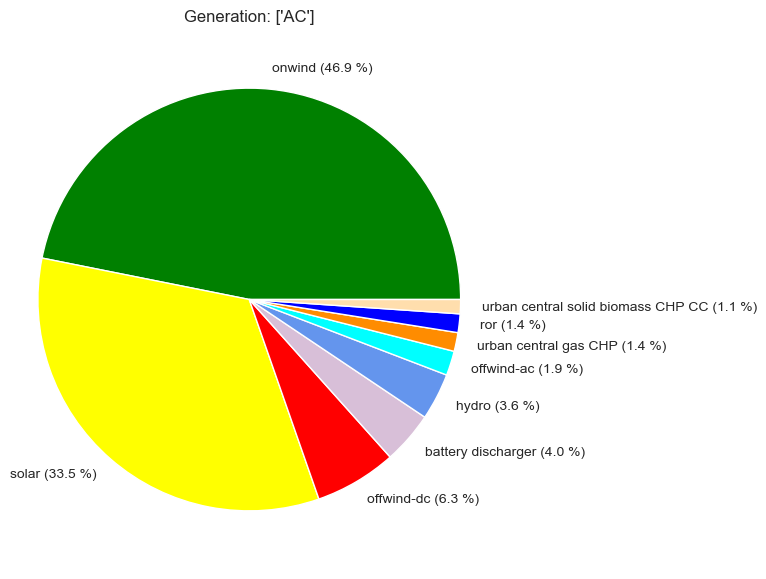

In [18]:
fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_ac_pos.index]
percents = nb_ac_pos.to_numpy() * 100 / nb_ac_pos.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_ac_pos.index,percents)]

patches, texts = ax.pie(nb_ac_pos, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Generation: {carrier}")
plt.show()

In [19]:
nb_ac_neg = abs(nb_ac.sum()[nb_ac.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 0.1 %
nb_ac_neg = nb_ac_neg[ (nb_ac_neg/ nb_ac_neg.sum()) > 0.005]

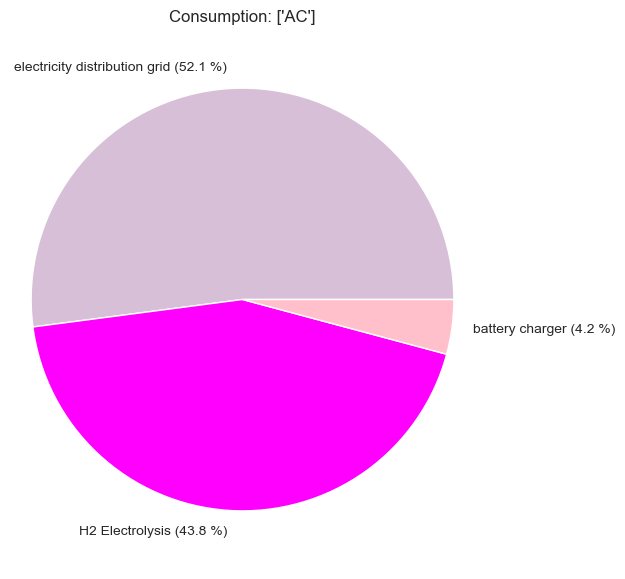

In [20]:
fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_ac_neg.index]
percents = nb_ac_neg.to_numpy() * 100 / nb_ac_neg.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_ac_neg.index,percents)]

patches, texts = ax.pie(nb_ac_neg, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Consumption: {carrier}")
plt.show()

#### H2

In [21]:
carrier = ["H2"]
nb_h2 = nodal_balance(n, carrier = carrier, time="2013", aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW
nb_h2 = nb_h2.unstack(level=[1]) / 1000
nb_h2.head()

carrier,Fischer-Tropsch,H2,H2 Electrolysis,H2 Fuel Cell,H2 for industry,H2 liquefaction,SMR,SMR CC,Sabatier,land transport fuel cell
snapshot,,,,,,,,,,
2013-01-01 00:00:00,-459.975204,-155.396314,1418.944234,NaN,-67.041096,-172.206968,0.128029,56.093250,-605.222151,-15.321848
2013-01-01 03:00:00,-486.941244,10.469678,1293.386199,NaN,-67.041096,-172.206968,0.128716,56.112605,-561.670608,-72.233524
2013-01-01 06:00:00,-493.860388,120.760838,1254.896087,NaN,-67.041096,-172.206968,0.136801,55.892113,-541.612172,-156.961786
2013-01-01 09:00:00,-477.600206,-529.096621,1850.339982,NaN,-67.041096,-172.206968,0.132124,53.077978,-528.729314,-128.869893
2013-01-01 12:00:00,-473.294329,-357.765792,1645.944470,NaN,-67.041096,-172.206968,0.134131,60.611015,-487.951933,-148.421112


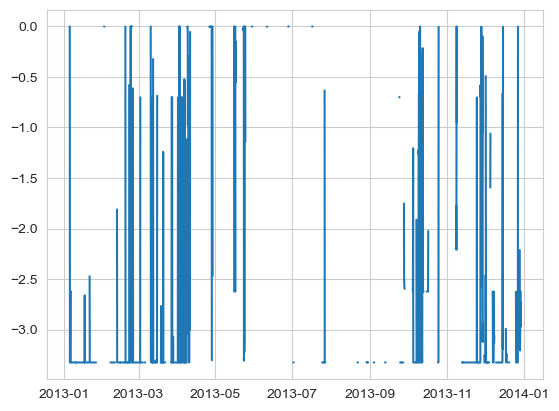

In [22]:
# what about the fuel cell?
plt.plot(nb_h2["H2 Fuel Cell"])

In [23]:
nb_h2_pos = nb_h2.sum()[nb_h2.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 0.1 %
nb_h2_pos = nb_h2_pos[ (nb_h2_pos/ nb_h2_pos.sum()) > 0.005]

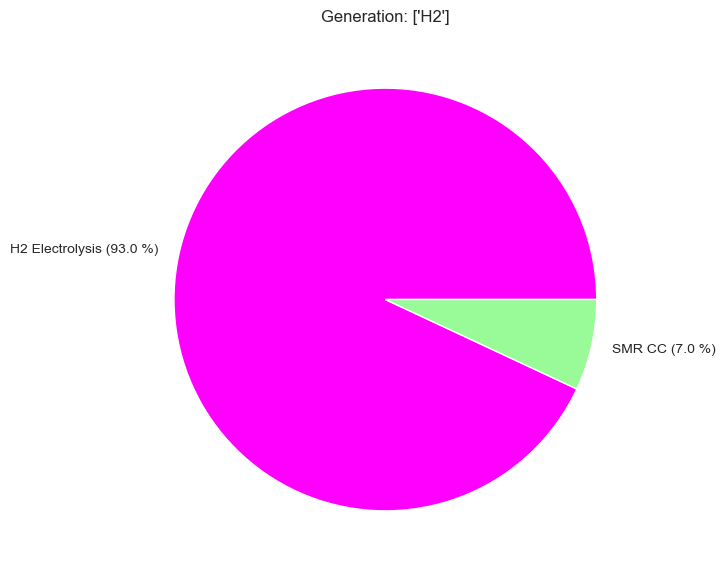

In [24]:
fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_h2_pos.index]
percents = nb_h2_pos.to_numpy() * 100 / nb_h2_pos.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_h2_pos.index,percents)]

patches, texts = ax.pie(nb_h2_pos, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Generation: {carrier}")
plt.show()

In [25]:
# Fuel Cell & H2 are irrelevant
abs(nb_h2.sum()[nb_h2.sum() < 0]).sort_values(ascending=False)

carrier
Fischer-Tropsch             1.421017e+06
Sabatier                    7.038010e+05
H2 liquefaction             5.028443e+05
land transport fuel cell    2.752584e+05
H2 for industry             1.957600e+05
H2 Fuel Cell                2.818275e+03
H2                          1.996724e-02
dtype: float64

In [26]:
nb_h2_neg = abs(nb_h2.sum()[nb_h2.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 0.1 %
nb_h2_neg = nb_h2_neg[ (nb_h2_neg/ nb_h2_neg.sum()) > 0.005]

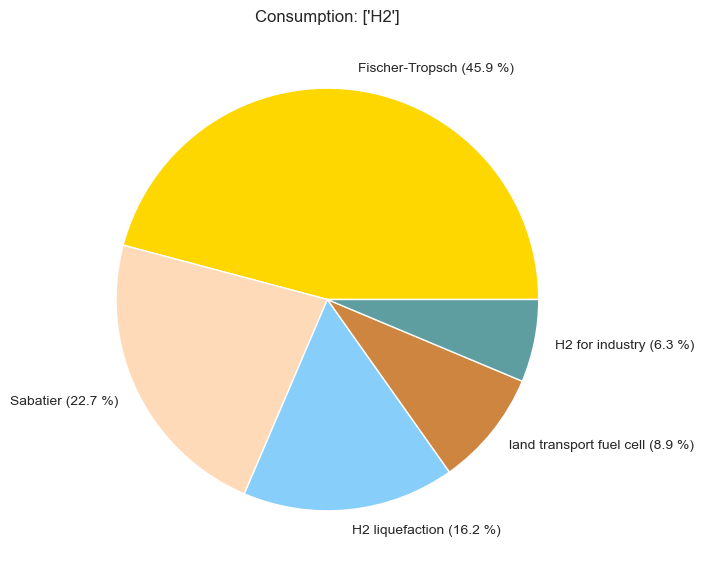

In [27]:
fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_h2_neg.index]
percents = nb_h2_neg.to_numpy() * 100 / nb_h2_neg.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_h2_neg.index,percents)]

patches, texts = ax.pie(nb_h2_neg, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Consumption: {carrier}")
plt.show()

#### Electricity

In [28]:
carrier = ["AC", "battery", "Li ion", "low voltage", "home battery"]
nb_el = nodal_balance(n, carrier = carrier, time="2013", aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW
nb_el = nb_el.unstack(level=[1]) / 1000
nb_el.head()

carrier,AC,BEV charger,DAC,DC,H2 Electrolysis,H2 Fuel Cell,Li ion,OCGT,PHS,V2G,...,services rural resistive heater,services urban decentral air heat pump,services urban decentral resistive heater,solar,solar rooftop,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central resistive heater,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.182343e-14,-47.165427,-4.701310,1.818989e-15,-2086.685643,NaN,-367.534527,NaN,-8.191668,-0.596872,...,NaN,-46.889870,-1.594791,NaN,NaN,-154.815092,26.784181,0.002446,-48.548865,72.685865
2013-01-01 03:00:00,1.455192e-14,-33.945003,-4.701299,-2.728484e-15,-1902.041094,NaN,-176.507583,NaN,2.064618,-0.824326,...,-10.438236,-54.976462,-28.055252,NaN,NaN,-158.089361,42.072599,0.002457,-137.468307,73.037867
2013-01-01 06:00:00,-2.182787e-14,-45.931335,-4.701317,2.273737e-15,-1845.437240,NaN,-8.074140,NaN,-9.096095,-0.178878,...,-9.875010,-55.011827,-28.963390,474.250993,52.107755,-160.161764,7.057945,0.002455,-168.944325,73.186171
2013-01-01 09:00:00,1.045919e-14,-82.758508,-4.702031,0.000000e+00,-2721.089244,NaN,-360.328960,NaN,-71.164409,-0.115199,...,-1.601324,-52.918497,-8.496117,2495.548835,231.050003,-160.160787,NaN,0.000776,-148.553123,71.994589
2013-01-01 12:00:00,-3.819878e-14,-73.882606,-4.702128,-9.094947e-16,-2420.508323,NaN,-268.930585,NaN,-17.166535,-0.104544,...,-0.286049,-50.526393,-3.678376,1958.283292,173.985753,-160.161781,2.023870,0.001828,-116.472971,72.584639


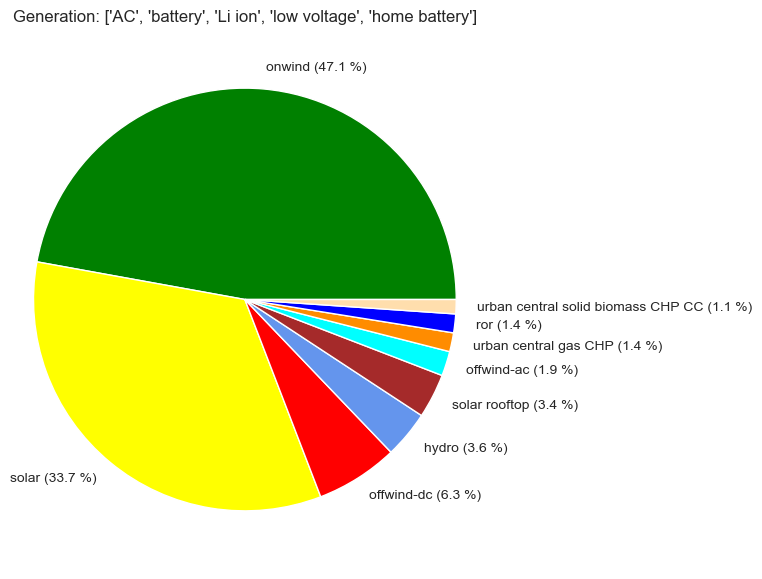

In [29]:
# Generation
nb_el_pos = nb_el.sum()[nb_el.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 0.5 %
nb_el_pos = nb_el_pos[(nb_el_pos / nb_el_pos.sum()) > 0.005]

fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_el_pos.index]
percents = nb_el_pos.to_numpy() * 100 / nb_el_pos.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_el_pos.index, percents)]

patches, texts = ax.pie(nb_el_pos, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Generation: {carrier}")
plt.show()

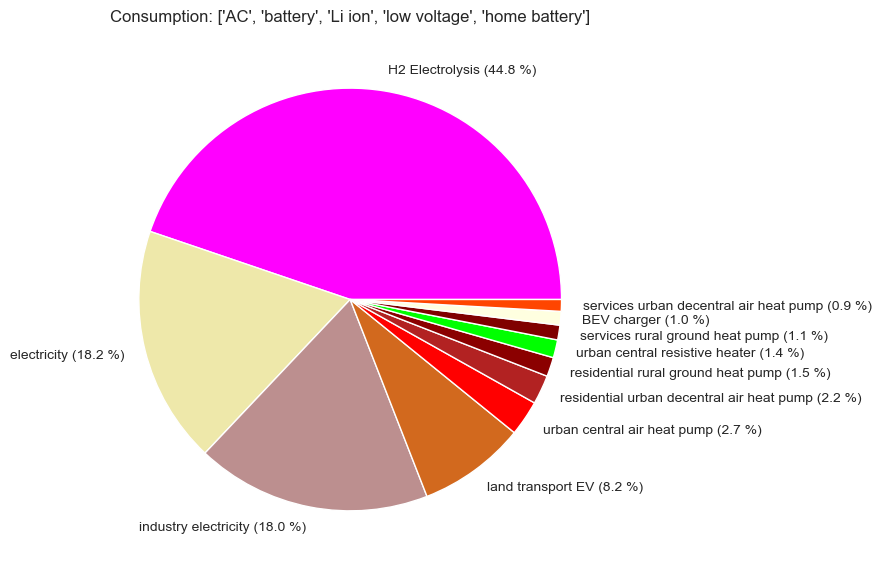

In [30]:
# Consumption
nb_el_neg = abs(nb_el.sum()[nb_el.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 0.5 %
nb_el_neg = nb_el_neg[(nb_el_neg / nb_el_neg.sum()) > 0.005]

fig, ax = plt.subplots(figsize=(6, 7))

c = [carrier_colors[col] for col in nb_el_neg.index]
percents = nb_el_neg.to_numpy() * 100 / nb_el_neg.to_numpy().sum()
labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_el_neg.index, percents)]

patches, texts = ax.pie(nb_el_neg, colors=c, startangle=0, labels=labels)
ax.axis('equal')

plt.title(f"Consumption: {carrier}")
plt.show()

## first plots

In [31]:
# create some interesting indices

# first hour: 1.1.2013 00:00:00 - 01:00:00
hour1 = n.generators_t.p.index <= datetime.datetime(2013,1,1,1)
# first day: 1.1.2013
day1 = n.generators_t.p.index <= datetime.datetime(2013,1,1)
# first month: january
month1 = n.generators_t.p.index < datetime.datetime(2013,1,31)

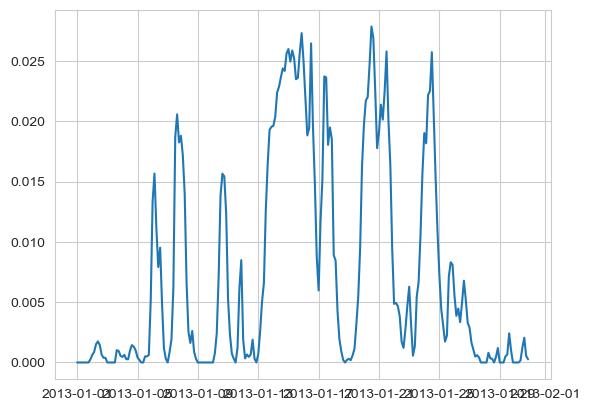

In [32]:
# generation of generator 'AL0 0 offwind-ac' for first month
plt.plot(n.generators_t.p['AL0 0 offwind-ac'][month1])

In [33]:
# names of the different generators
n.generators_t.p.columns

Index(['AL0 0 offwind-ac', 'AL0 0 onwind', 'AL0 0 solar', 'AT0 0 onwind',
       'AT0 0 ror', 'AT0 0 solar', 'AT0 1 onwind', 'AT0 1 ror', 'AT0 1 solar',
       'AT0 2 onwind',
       ...
       'RS0 1 solar rooftop', 'SE3 0 solar rooftop', 'SE3 1 solar rooftop',
       'SE3 2 solar rooftop', 'SE3 3 solar rooftop', 'SE3 5 solar rooftop',
       'SE3 6 solar rooftop', 'SE3 7 solar rooftop', 'SI0 0 solar rooftop',
       'SK0 0 solar rooftop'],
      dtype='object', name='Generator', length=1707)

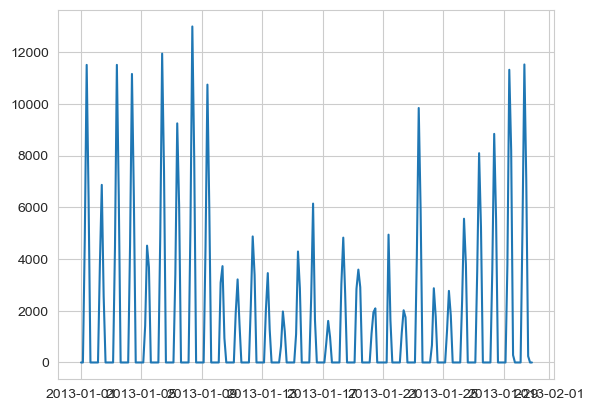

In [34]:
plt.plot(n.generators_t.p[month1]['AL0 0 solar'])

In [35]:
# market values: "onwind", "solar", "solar rooftop", "offwind-dc", "offwind-ac"
mv_onwind = market_values(n, "onwind")
mv_onwind

Generator
AL0 0    131.075254
AT0 0     83.457109
AT0 1     84.612302
AT0 2     90.012931
BA0 0    119.715551
            ...    
SE3 5     60.351733
SE3 6     53.277864
SE3 7     63.297661
SI0 0    125.246390
SK0 0     91.144751
Length: 181, dtype: float64

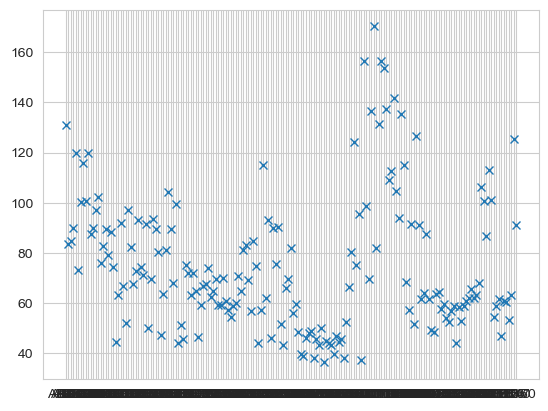

In [36]:
plt.plot(mv_onwind,'x')

In [37]:
# shadow prices (in €/MWh) for every nod/bus and time step
# (e.g. Locational Marginal Price (LMP) for electricity)
n.buses_t.marginal_price

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,208.089324,187.447538,132.306353,87210.617893,203.956540,207.193448,208.101095,56.974139,58.124200,98.687337,...,37.759799,125.280135,118.864605,118.047631,100.123259,-513.283465,-358.677321,113.318707,-414.293975,78.325642
2013-01-01 03:00:00,208.030183,187.447686,132.305622,132.315961,203.902052,205.714306,208.041610,57.018315,60.356861,231.005065,...,123.354232,131.588893,127.508619,119.289047,100.193499,-513.283465,-358.677360,113.334089,-412.864209,78.419905
2013-01-01 06:00:00,153.808216,187.447826,132.304178,132.314517,156.989409,169.934834,168.694456,185.978154,162.287216,187.391199,...,127.469042,131.586472,131.094079,119.372125,100.263177,-513.283465,-358.677378,113.349609,-412.188901,78.490917
2013-01-01 09:00:00,89.821566,182.553882,132.127980,132.138319,156.989293,167.097474,164.289516,45.035153,48.301899,125.271125,...,125.676186,125.283858,128.344296,119.430310,100.331808,-513.283465,-358.677391,113.365708,-411.875232,78.559337
2013-01-01 12:00:00,153.339481,182.554338,132.303825,132.314163,156.989346,167.635541,164.290191,45.045361,48.062406,125.255829,...,124.979069,125.281745,128.271108,119.428606,100.400904,-513.283465,-358.677399,113.395103,-411.642917,78.642735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,199.844657,187.446471,132.308110,132.318449,203.986154,201.531371,199.854464,56.431556,57.994492,79.089352,...,37.617372,125.278126,126.196737,118.054180,99.774169,-513.283465,-358.677308,112.957515,-407.839459,78.502628
2013-12-31 12:00:00,199.855407,187.446782,132.308083,132.318421,203.986169,202.085946,199.865679,56.451729,58.044303,77.418336,...,36.567638,125.275258,125.383352,118.052955,99.843746,-513.283465,-358.677296,112.949373,-407.825246,78.497642
2013-12-31 15:00:00,208.203744,187.447032,132.307921,132.318259,203.986319,206.444218,208.217403,58.830340,58.841772,125.150310,...,37.770381,125.276215,123.458995,118.054432,99.913423,-513.283465,-358.677267,112.944123,-407.815666,78.487410


In [38]:
carrier = "onwind"
# select all the generators for specific carrier e.g. onwind
gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
# create index from the generators and use as column names
gen.columns = gen.columns.map(n.generators.bus)
# get locational marginal prices for all locations and all time steps
lmp = n.buses_t.marginal_price.loc[:, gen.columns]

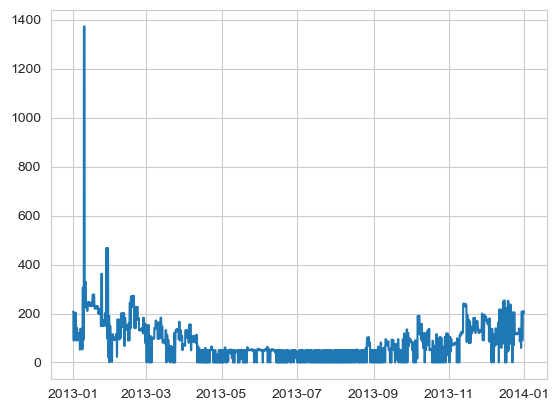

In [39]:
# plot of lmp of AL0 0
plt.plot(lmp["AL0 0"])

In [40]:
# calculate market values as sum product of generation times lmp divided by total generation
mv = (gen * lmp).sum() / gen.sum()
# set location of the buses/nodes as the index -> shape = (n_generators x 1) 1 col with mvs
mv.index = mv.index.map(n.buses.location)

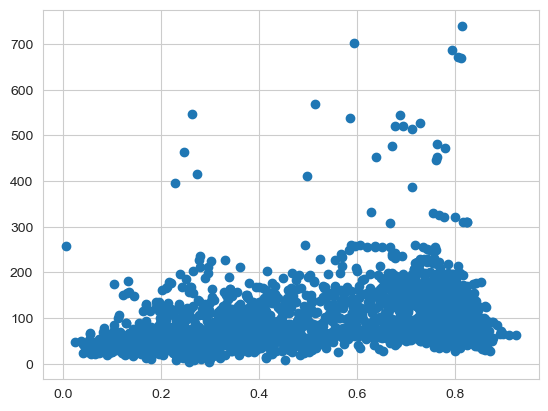

In [41]:
# plot: carrier market value plotted against carrier share
market_share = gen.sum(axis=1) / n.generators_t.p.sum(axis=1)
plt.scatter(market_share, lmp.mean(axis=1))

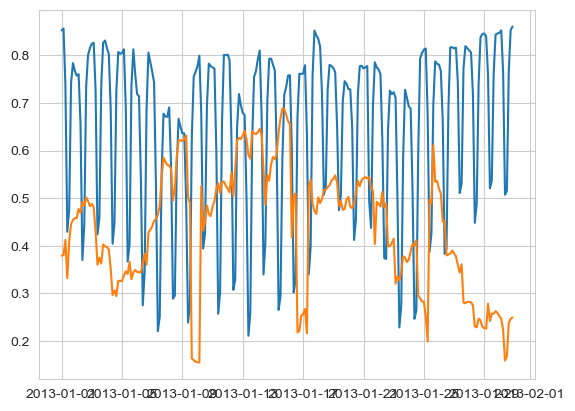

In [42]:
plt.plot(market_share[month1])
plt.plot((lmp.mean(axis=1)/lmp.max(axis=1))[month1])

In [43]:
lmp.mean(axis=1)

snapshot
2013-01-01 00:00:00    85.479561
2013-01-01 03:00:00    85.802057
2013-01-01 06:00:00    80.220032
2013-01-01 09:00:00    62.647400
2013-01-01 12:00:00    79.642487
                         ...    
2013-12-31 09:00:00    67.913761
2013-12-31 12:00:00    83.950352
2013-12-31 15:00:00    94.985838
2013-12-31 18:00:00    94.840804
2013-12-31 21:00:00    94.195651
Length: 2920, dtype: float64

In [44]:
market_share

snapshot
2013-01-01 00:00:00    0.852412
2013-01-01 03:00:00    0.856350
2013-01-01 06:00:00    0.737621
2013-01-01 09:00:00    0.429234
2013-01-01 12:00:00    0.476010
                         ...   
2013-12-31 09:00:00    0.454882
2013-12-31 12:00:00    0.475002
2013-12-31 15:00:00    0.760517
2013-12-31 18:00:00    0.817064
2013-12-31 21:00:00    0.820200
Length: 2920, dtype: float64

In [45]:
test = pd.concat([market_share, lmp.mean(axis=1)], axis=1)
test.columns = ["market_share", "lmp"]
test.set_index("market_share", inplace=True)
test.sort_index(ascending=True)

,lmp
market_share,
0.004559,257.072458
0.024893,48.411784
0.035941,50.121329
0.039467,42.834398
0.040391,42.570327
...,...
0.890092,64.655837
0.893312,70.894865
0.898062,65.795213


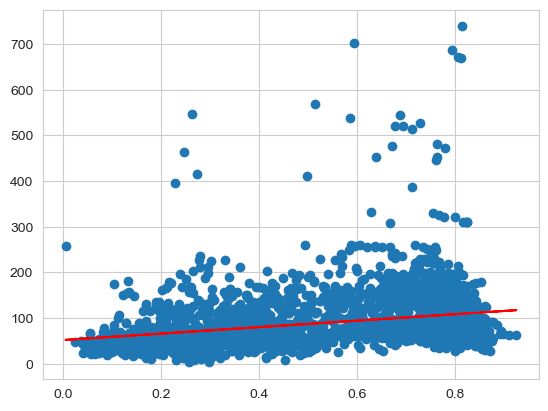

In [46]:
plt.scatter(test.index, test.lmp)
m, b = np.polyfit(test.index, test.lmp, 1)
plt.plot(test.index, m*test.index+b, color="red")

In [47]:
mv_onwind = market_values(n,"onwind")

In [48]:
# Link between two buses with controllable active power - can be used for a transport power flow model OR as a simplified version of point-to-point DC connection OR as a lossy energy converter. NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1. NB: It is assumed that the links neither produce nor consume reactive power.

n.links_t.p0

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-373.224322,-249.993237,0.0,0.0,0.0,0.0,599.976038,-499.963378,999.540578,-597.418961,...,0.0,0.0,0.0,0.0,0.0,0.032368,33597.122837,0.001197,0.017103,89091.812555
2013-01-01 03:00:00,-437.541123,-249.993058,0.0,0.0,0.0,0.0,516.626986,-499.965632,999.966753,-599.975228,...,0.0,0.0,0.0,0.0,0.0,0.032540,33597.122647,0.001188,0.017149,89091.812503
2013-01-01 06:00:00,515.030831,-249.993312,0.0,0.0,0.0,0.0,22.926537,-499.996982,999.971128,-599.927696,...,0.0,0.0,0.0,0.0,0.0,0.032681,33597.122490,0.001184,0.017191,89091.812457
2013-01-01 09:00:00,999.992935,-249.986233,0.0,0.0,0.0,0.0,-0.003338,499.961155,999.971371,-599.972055,...,0.0,0.0,0.0,0.0,0.0,0.032795,33597.122364,0.001184,0.017225,89091.812419
2013-01-01 12:00:00,-999.753630,-249.992932,0.0,0.0,0.0,0.0,-17.666072,336.640918,999.971740,-599.885795,...,0.0,0.0,0.0,0.0,0.0,0.032924,33597.122220,0.001187,0.017272,89091.812366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-234.716347,-249.992745,0.0,0.0,0.0,0.0,51.158434,-499.954895,560.748082,-599.886990,...,0.0,0.0,0.0,0.0,0.0,0.034309,33597.120681,0.001410,0.017514,89091.812098
2013-12-31 12:00:00,-999.993634,-249.992624,0.0,0.0,0.0,0.0,17.963294,-499.957181,347.496530,-599.886507,...,0.0,0.0,0.0,0.0,0.0,0.034310,33597.120680,0.001408,0.017511,89091.812101
2013-12-31 15:00:00,45.771531,-249.992412,0.0,0.0,0.0,0.0,8.645707,-499.940458,998.984391,-599.884190,...,0.0,0.0,0.0,0.0,0.0,0.034304,33597.120686,0.001404,0.017508,89091.812104


In [49]:
n.components

{'Network': {'list_name': 'networks',
  'description': 'Container for all components and functions which act upon the whole network.',
  'type': nan,
  'attrs':                                                          type     unit  \
  attribute                                                                
  name                                                   string      NaN   
  snapshots                                list or pandas.Index      NaN   
  snapshot_weightings                          pandas.DataFrame   hours    
  investment_periods                               pandas.Index    years   
  investment_period_weightings                 pandas.DataFrame      NaN   
  now                                                       any      NaN   
  srid                                                  integer      NaN   
  buses                                        pandas.DataFrame      NaN   
  buses_t                       dictionary of pandas.DataFrames      NaN   
  lin

In [50]:
# market value for the 181 onwind generators (k-mean clusters)
mv_onwind

Generator
AL0 0    131.075254
AT0 0     83.457109
AT0 1     84.612302
AT0 2     90.012931
BA0 0    119.715551
            ...    
SE3 5     60.351733
SE3 6     53.277864
SE3 7     63.297661
SI0 0    125.246390
SK0 0     91.144751
Length: 181, dtype: float64

In [51]:
p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 1700.0]).index, axis=1, inplace=True
)
p_by_carrier.columns

Index(['gas', 'offwind-ac', 'offwind-dc', 'oil', 'onwind', 'ror', 'solar',
       'solar rooftop', 'urban central solar thermal'],
      dtype='object', name='carrier')

In [52]:
colors = {
    "oil": "k",
    "offwind-dc": "r",
    "onwind": "green",
    "ror": "blue",
    "solar": "yellow",
    "offwind-ac": "cyan",
    "solar rooftop": "brown",
    "gas": "orange",
    "urban central solar thermal": "pink"
}
# reorder
cols = [
    "oil",
    "gas",
    "ror",
    "offwind-ac",
    "offwind-dc",
    "onwind",
    "solar",
    "solar rooftop",
    "urban central solar thermal",
]
p_by_carrier = p_by_carrier[cols]

In [53]:
p_by_carrier.max()

carrier
oil                            3.728034e+03
gas                            2.770290e+07
ror                            2.999174e+04
offwind-ac                     4.498734e+04
offwind-dc                     1.273127e+05
onwind                         1.388716e+06
solar                          1.714094e+06
solar rooftop                  1.982147e+05
urban central solar thermal    4.327395e+04
dtype: float64

In [54]:
(p_by_carrier / 1e3).max()

carrier
oil                                3.728034
gas                            27702.904377
ror                               29.991739
offwind-ac                        44.987345
offwind-dc                       127.312654
onwind                          1388.715919
solar                           1714.093552
solar rooftop                    198.214661
urban central solar thermal       43.273947
dtype: float64

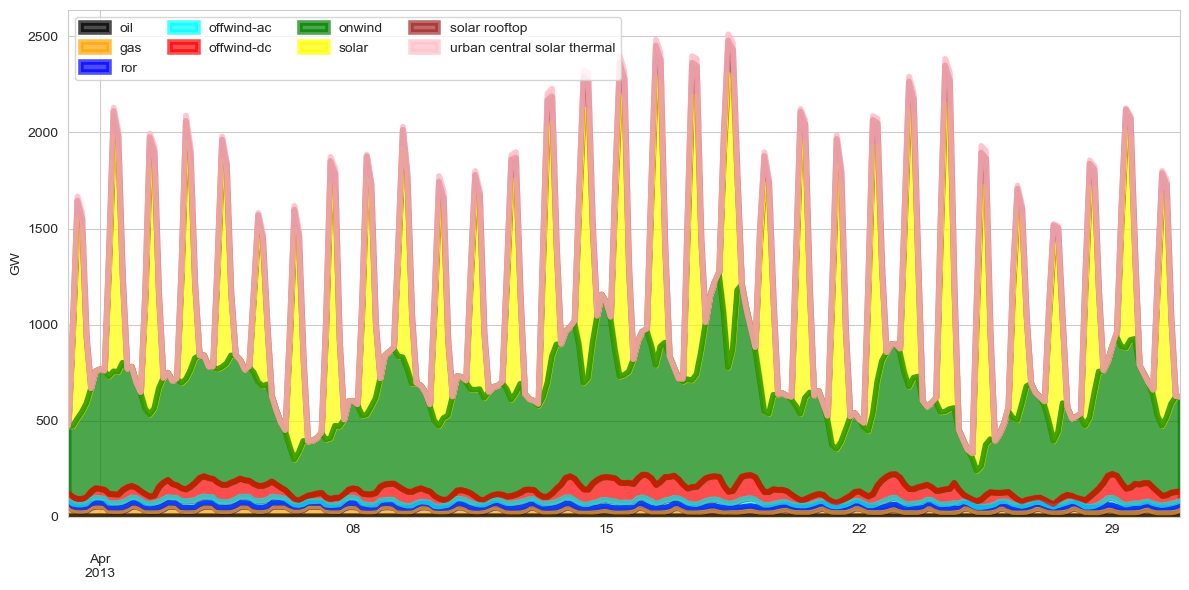

In [55]:
index = (p_by_carrier.index > datetime.datetime(2013,3,31)) & (p_by_carrier.index < datetime.datetime(2013,5,1)) # huge peak for 16.02
c = [colors[col] for col in p_by_carrier.columns]

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier[index] / 1e3).plot(kind="area", ax=ax, linewidth=4, color=c, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

In [56]:
p_by_carrier[index]

carrier,oil,gas,ror,offwind-ac,offwind-dc,onwind,solar,solar rooftop,urban central solar thermal
snapshot,,,,,,,,,
2013-03-31 03:00:00,3619.783404,51980.834313,17701.334506,14682.534995,34703.489085,349380.148334,2.169657e+03,247.048992,0.000000
2013-03-31 06:00:00,3618.879587,32567.912519,17712.796732,14372.434175,35476.660126,369568.864937,4.983410e+05,48289.446144,1122.074520
2013-03-31 09:00:00,3620.746206,27346.053247,17527.730509,14683.970727,31408.411538,417266.231342,1.035932e+06,98500.296392,22221.157343
2013-03-31 12:00:00,3620.751043,26852.583408,17668.796411,15233.812608,31267.768819,451747.564767,9.248659e+05,84991.391501,27909.493236
2013-03-31 15:00:00,3619.618492,28885.803375,17874.020495,17578.147783,35109.969332,487665.862813,3.192337e+05,30062.078517,6613.916995
...,...,...,...,...,...,...,...,...,...
2013-04-30 09:00:00,3657.912176,18564.908436,25527.996628,12829.887341,50264.707402,362909.606536,1.200630e+06,115843.525893,11434.156968
2013-04-30 12:00:00,3657.771576,18464.309486,25664.925707,16244.958686,50547.470211,403531.090936,1.116100e+06,100152.500353,20386.371719
2013-04-30 15:00:00,3655.551924,18589.130556,25857.282995,20477.470857,58253.770521,461232.394482,4.299384e+05,34420.197898,4326.138593


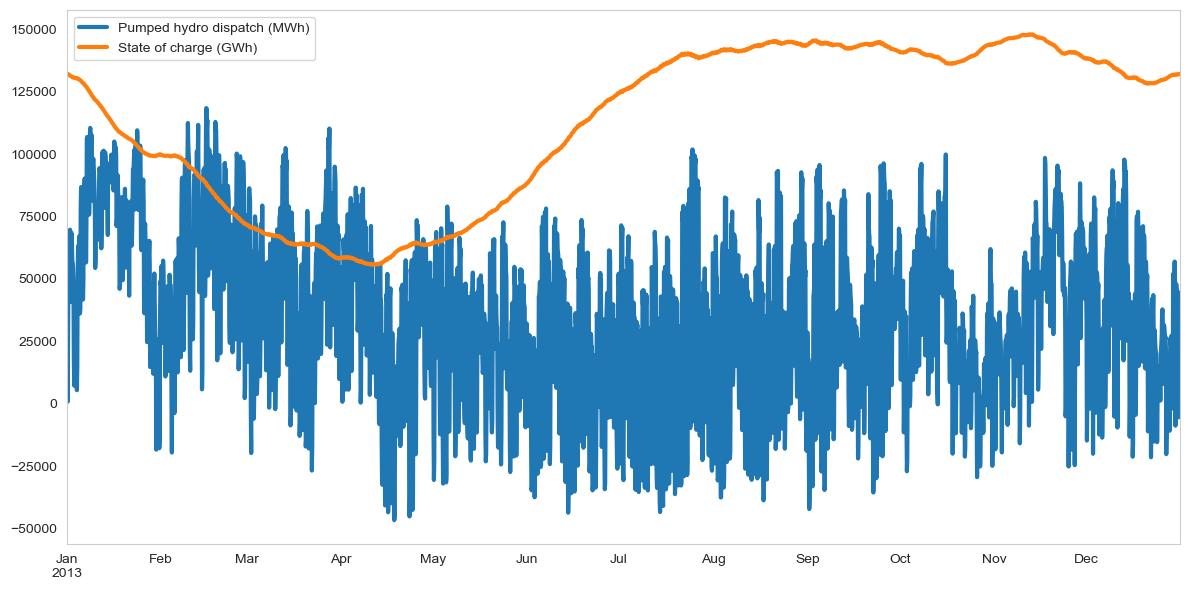

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))

p_storage = n.storage_units_t.p.sum(axis=1)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1) / 1e3
p_storage.plot(label="Pumped hydro dispatch (MWh)", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge (GWh)", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("")
ax.set_xlabel("")
fig.tight_layout()

In [58]:
# marginal prices
n.buses_t.marginal_price.loc[snap].describe()

count     3086.000000
mean      5117.495124
std      20367.639065
min       -513.283465
25%         23.874090
50%         50.352595
75%        101.823800
max      87381.618156
Name: 2013-01-01 00:00:00, dtype: float64

In [59]:
n.buses[n.buses.x != 0].index

Index(['AL0 0', 'AT0 0', 'AT0 1', 'AT0 2', 'BA0 0', 'BE0 0', 'BE0 1', 'BE0 2',
       'BE0 3', 'BE0 4',
       ...
       'SE3 0', 'SE3 1', 'SE3 2', 'SE3 3', 'SE3 4', 'SE3 5', 'SE3 6', 'SE3 7',
       'SI0 0', 'SK0 0'],
      dtype='object', name='Bus', length=181)

In [60]:
n.buses_t.marginal_price.loc[snap,n.buses[n.buses.x != 0].index]

Bus
AL0 0    208.089324
AT0 0    194.476915
AT0 1    112.846308
AT0 2    172.160743
BA0 0    205.723920
            ...    
SE3 5     42.756983
SE3 6     64.759374
SE3 7     38.437357
SI0 0    199.467294
SK0 0    118.415914
Name: 2013-01-01 00:00:00, Length: 181, dtype: float64

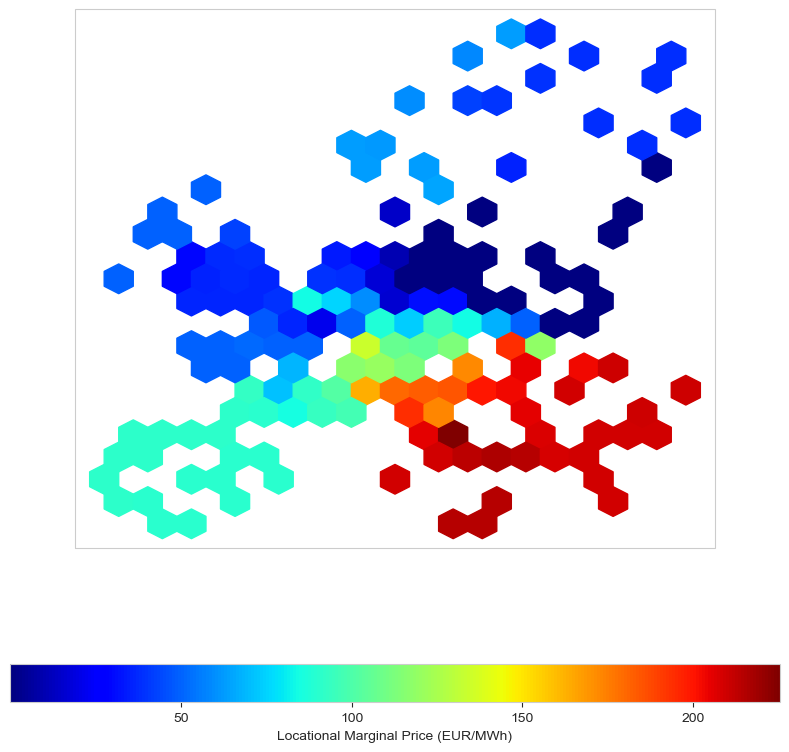

In [61]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    n.buses[n.buses.x != 0].x,
    n.buses[n.buses.x != 0].y,
    gridsize=20,
    C=n.buses_t.marginal_price.loc[snap,n.buses[n.buses.x != 0].index],
    cmap=plt.cm.jet,
    zorder=3,
)
# n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index), bus_sizes=0)

cb = plt.colorbar(location="bottom")
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()

## Market values general investigation

In [62]:
carriers_buses = n.buses.carrier.unique().tolist()
carriers_gens = n.generators.carrier.unique().tolist()
carriers_links = n.links.carrier.unique().tolist()
carriers_buses
carriers_gens
carriers_links

['DC',
 'OCGT',
 'H2 Electrolysis',
 'H2 Fuel Cell',
 'battery charger',
 'battery discharger',
 'Sabatier',
 'SMR CC',
 'SMR',
 'BEV charger',
 'V2G',
 'residential rural ground heat pump',
 'residential rural water tanks charger',
 'residential rural water tanks discharger',
 'residential rural resistive heater',
 'residential rural gas boiler',
 'services rural ground heat pump',
 'services rural water tanks charger',
 'services rural water tanks discharger',
 'services rural resistive heater',
 'services rural gas boiler',
 'residential urban decentral air heat pump',
 'residential urban decentral water tanks charger',
 'residential urban decentral water tanks discharger',
 'residential urban decentral resistive heater',
 'residential urban decentral gas boiler',
 'services urban decentral air heat pump',
 'services urban decentral water tanks charger',
 'services urban decentral water tanks discharger',
 'services urban decentral resistive heater',
 'services urban decentral gas b

In [63]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [64]:
# market values for generators
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers_gens)

for carrier in carriers_gens:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

,offwind-ac,onwind,solar,ror,offwind-dc,gas,residential rural solar thermal,services rural solar thermal,residential urban decentral solar thermal,services urban decentral solar thermal,urban central solar thermal,oil,solar rooftop
AL0 0,126.148417,131.075254,44.628736,NaN,NaN,NaN,28.100521,28.138751,36.469361,35.507220,45.096866,NaN,56.499070
AT0 0,NaN,83.457109,54.679083,87.946522,NaN,NaN,25.297088,25.674329,34.858212,34.521443,39.641186,NaN,64.462333
AT0 1,NaN,84.612302,65.745903,97.282183,NaN,NaN,48.136420,48.114128,57.898941,58.635892,38.246840,NaN,77.031453
AT0 2,NaN,90.012931,58.223787,85.291980,NaN,NaN,36.920372,36.785644,50.714563,49.973918,40.517487,NaN,69.284880
BA0 0,NaN,119.715551,51.160537,NaN,NaN,NaN,27.930405,26.504637,37.326041,36.184464,33.059630,NaN,58.363750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 6,60.483666,53.277864,58.963028,77.032750,60.000468,NaN,36.445496,36.991150,42.670140,41.596612,38.443884,NaN,68.822199
SE3 7,59.877949,63.297661,60.256194,66.164361,60.578980,NaN,28.425435,27.717632,6.907004,20.114828,35.763463,NaN,63.005445
SI0 0,148.386481,125.246390,60.556211,111.663140,NaN,NaN,28.066113,26.536094,36.636030,35.702336,39.247357,NaN,62.729094
SK0 0,NaN,91.144751,54.957441,93.823663,NaN,NaN,21.491470,22.449092,29.961099,28.937610,34.316675,NaN,61.104808


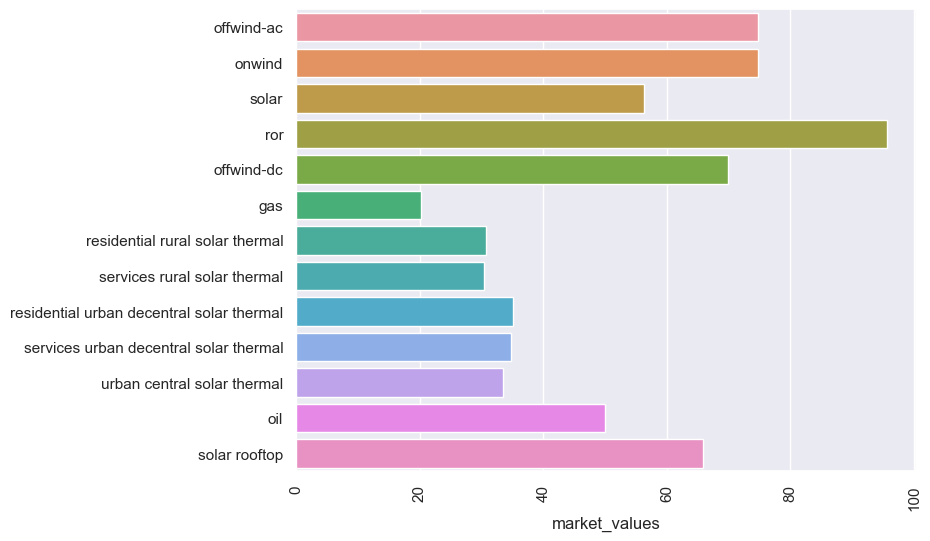

In [65]:
# plot overall market value for all carriers in generators

mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

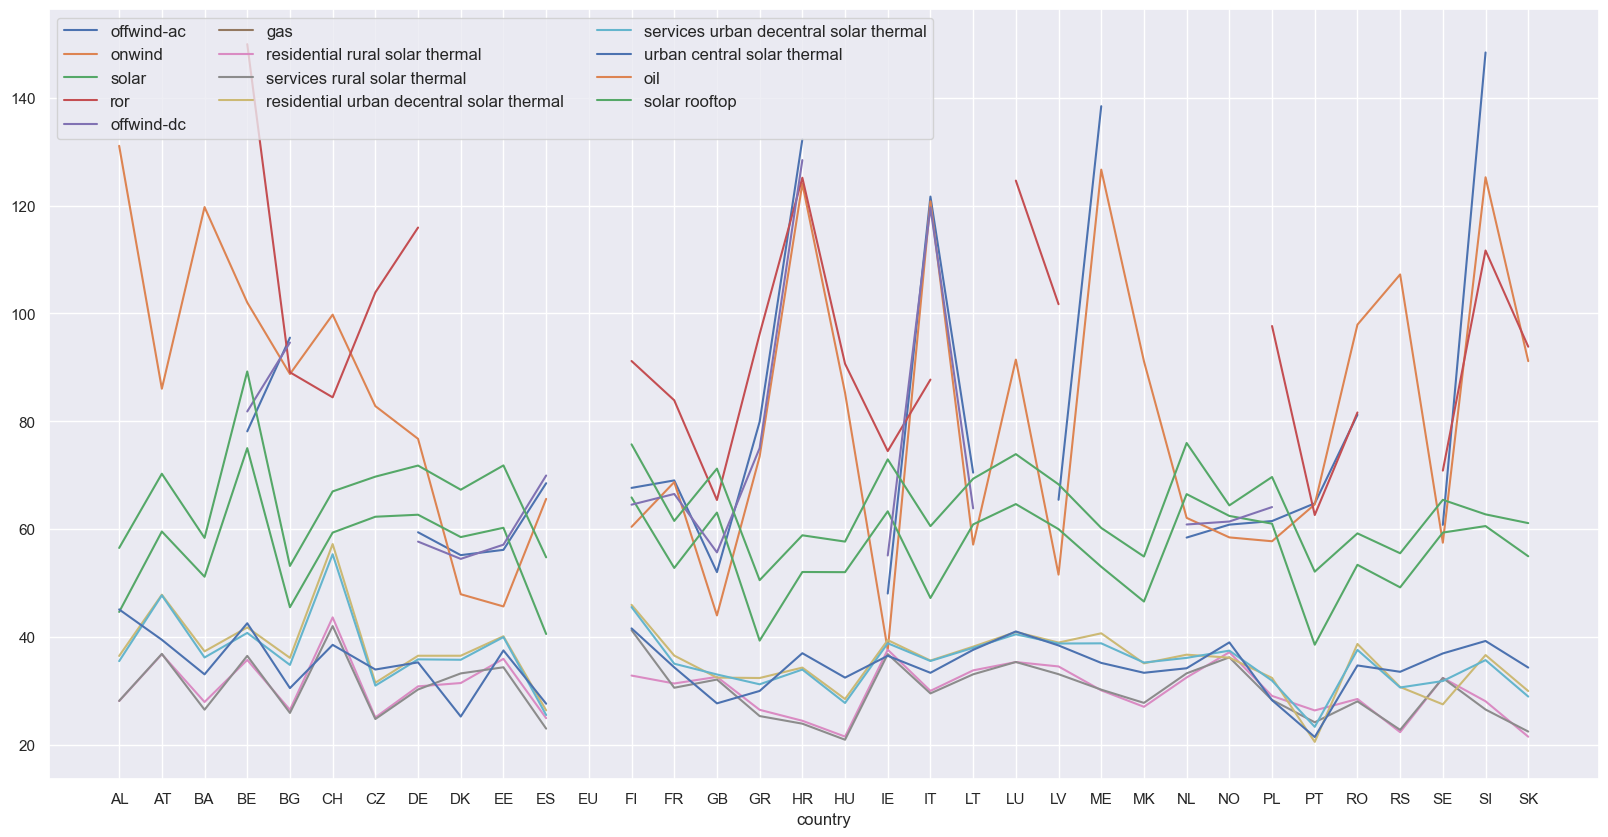

In [66]:
# Plot of mv of carriers by country
mv_carriers["country"] = mv_carriers.index.str[:2]
ax = mv_carriers.groupby(by="country").mean().plot(figsize=(20,10))
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_carriers.groupby(by="country").mean())))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.groupby(by="country").mean().index.tolist()], rotation=0)

In [67]:
# # Plot of market values of carriers for periods
days = pd.DatetimeIndex(np.unique(n.generators_t.p.index.date))
# plt.figure(figsize=(15, 10))
#
# for carrier in car_gen_vre:
#     mv = market_values_by_time_index(n, days, carrier)
#     plt.plot(mv.mean(axis=1), label=carrier)
#
# plt.legend()

In [68]:
# # Plot of all locational marginal prices over all carriers per regions
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
# df1 = lmp_regions.mean()
# sns.set(rc={'figure.figsize':(10,30)})
# ax = sns.barplot(y=df1.index, x=df1.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

In [69]:
# # Plot of lmp over all carriers averaged over countries
# df2 = lmp_regions.transpose()
# df2["country"] = df2.index.str[:2]
# df2 = df2.groupby(by="country").mean().mean(axis=1)
# sns.set(rc={'figure.figsize':(10,7)})
# ax = sns.barplot(y=df2.index, x=df2.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

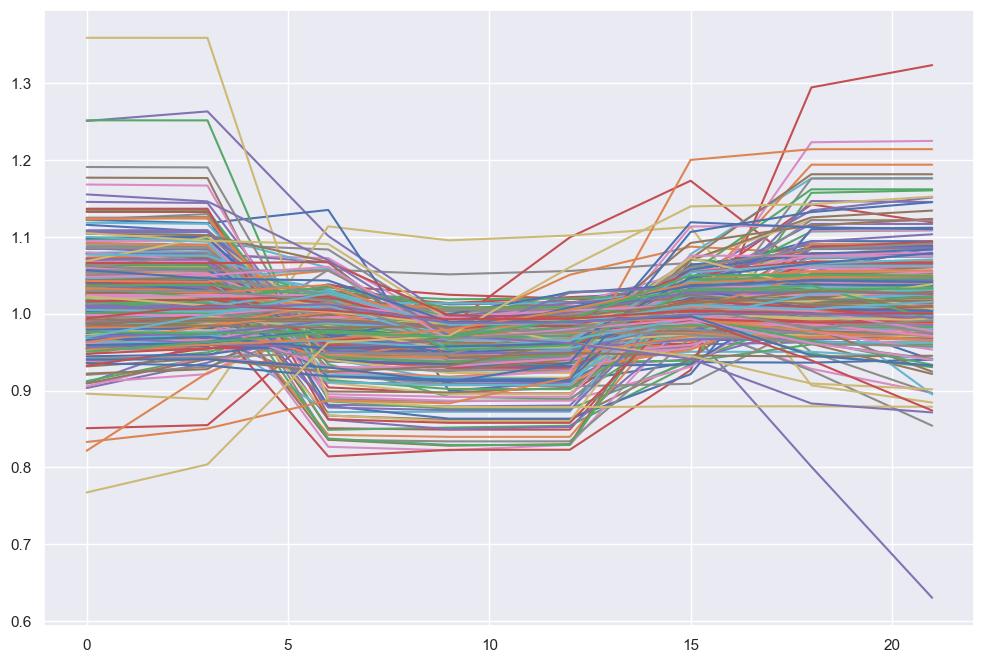

In [70]:
# Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the day
plt.figure(figsize=(12, 8))

carrier_bus = "H2" #carriers_buses
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index]

for day in days:
    df = lmps[lmps.index.date == day.date()].mean(axis=1)
    df_normalized = df / df.mean()
    plt.plot(df_normalized.index.hour, df_normalized.values)

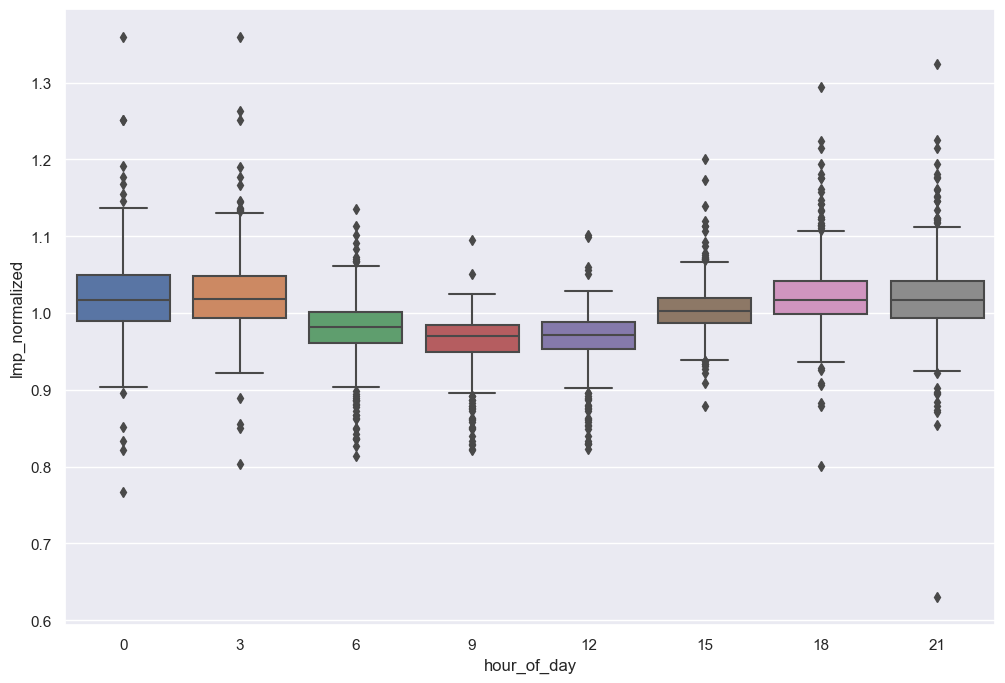

In [71]:
# # Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the current day
plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmps.mean(axis=1))
df3.columns = ["lmp"]
df3["lmp_normalized"] = np.nan

for snap in df3.index:
    df3.loc[snap, "lmp_normalized"] = df3.loc[snap, "lmp"] / df3[df3.index.date == snap.date()].lmp.mean()

df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="lmp_normalized", x="hour_of_day")
plt.show()

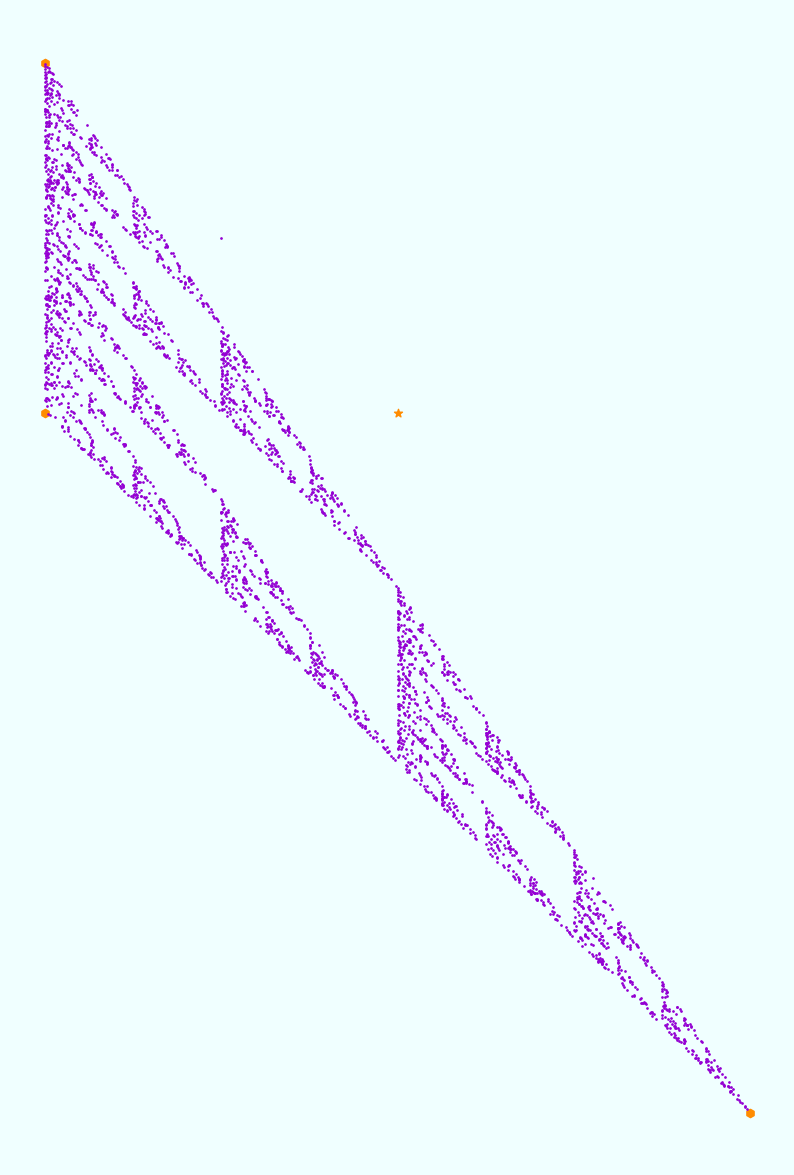

In [44]:
# simulation fractal
from shapely.geometry import Point
import random

def midpoint(p1, p2):
    return Point((p1.x+p2.x)/2, (p1.y+p2.y)/2)

def get_coords(list):
    xs = [point.x for point in list]
    ys = [point.y for point in list]
    return xs, ys

n = 11*365
a, b, c = Point(0,2), Point(0,3), Point(2, 0)
start_point = Point(1, 2)
points = [a, b, c]
more_points = []

fig = plt.figure(figsize=(10, 15))
xs, ys = get_coords(points)
plt.scatter(xs, ys, marker="h", color="darkorange")

plt.scatter(start_point.x, start_point.y, marker="*", color="darkorange")

for i in range(n):
    next_point = midpoint(start_point, random.choice(points))
    more_points.append(next_point)
    start_point = next_point

xs, ys = get_coords(more_points)
plt.scatter(xs, ys, s=0.9, color="darkviolet")

plt.grid(False)
plt.axis('off')
fig.set_facecolor('azure')

plt.show()